In [1]:
# 當電腦資源不夠時可以利用colab來進行modal的訓練
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# # 下載基於 keras 的 yolov3 程式碼
# %cd 'gdrive/My Drive'
# #!git clone https://github.com/qqwweee/keras-yolo3 # 如果之前已經下載過就可以註解掉
# %ls

D:\Python\keras-yolo3
Model exist
D:\Python


In [1]:
import os
import shutil
import numpy as np
import random
import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
import time

# 圖像處理相關函式庫
import cv2
from PIL import Image, ImageFile, ImageFont
from yolo import YOLO

# 將 train.py 所需要的套件載入
# import keras.backend as K
# from keras.layers import Input, Lambda
# from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
# from yolo3.utils import get_random_data
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper


%cd keras-yolo3

if not os.path.exists("model_data/yolo.h5"):
    print("Model doesn't exist, downloading...")
    os.system("wget https://pjreddie.com/media/files/yolov3.weights")
    print("Converting yolov3.weights to yolo.h5...")
    os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
    print("Model exist")
    
%cd ../


Using TensorFlow backend.


D:\Python\keras-yolo3
Model exist
D:\Python


- 定義圖像的類別

在這個圖像資料集裡有2種類別:

> - kangaroo
> - raccoon

In [2]:
# 圖像類別的Label-encoding
classes = ["kangaroo", "raccoon"]

# 取得所有圖像的圖像類別列表
labels=len(classes)

- 採隨機分配的方式，分別建置train、validation、test的資料夾，各個資料夾下包含images、annotations的資料夾，用來放相關的data

In [2]:
# copy random file to folder
kangaroo_path = "1stDL/Day049-050/kangaroo-master"
raccoon_path = "1stDL/Day049-050/raccoon_dataset-master"
train_path = "1stDL/Day049-050/train"
validation_path = "1stDL/Day049-050/validation"
test_path = "1stDL/Day049-050/test"

image_path = "/images"
annotations_path = "/annotations"

# 切分 train、validation、test
validation_split = 0.1
test_split = 0.1
train_split = 1

#取得所有XML檔的檔名
kangaroo_image_file = os.listdir(kangaroo_path + "/images")
kangaroo_xml_file = os.listdir(kangaroo_path + "/annots")
raccoon_image_file = os.listdir(raccoon_path + "/images")
raccoon_xml_file = os.listdir(raccoon_path + "/annotations")

In [ ]:
# 清除train、validation、test資料夾 重新創建資料夾路徑
def reset_file(path, type):
    try:
        shutil.rmtree(path)
        print("clear finish %s path ~" % type)
    except Exception as e:
        print("don't have %s path ~" % type)
    os.makedirs(path + image_path)
    os.makedirs(path + annotations_path)

reset_file(train_path, "train")
reset_file(validation_path, "validation")
reset_file(test_path, "test")

# 根據相對應的路徑抓取隨機的檔案，並複製到不同類型的資料夾下
def copy_file_to_path(file_path, images_path, type, weights):
    for i in range(round(len(images_path) * weights)):
        num = random.randint(0, len(images_path) - 1)
        images = images_path.pop(num)
        shutil.copy2(file_path + "/images/" + images, type + image_path)
        xml_file = images.replace(".jpg", ".xml")
        if file_path.count("kangaroo-master") == 1:
            shutil.copy2(file_path + "/annots/" + xml_file, type + annotations_path)
        else:
            shutil.copy2(file_path + "/annotations/" + xml_file, type + annotations_path)
    
# 分別建置train、test、validation資料夾 images、annots裡面的檔案
# kangaroo
copy_file_to_path(kangaroo_path, kangaroo_image_file, test_path, test_split)
copy_file_to_path(kangaroo_path, kangaroo_image_file, validation_path, validation_split)
copy_file_to_path(kangaroo_path, kangaroo_image_file, train_path, train_split)

# raccoon
copy_file_to_path(raccoon_path, raccoon_image_file, test_path, test_split)
copy_file_to_path(raccoon_path, raccoon_image_file, validation_path, validation_split)
copy_file_to_path(raccoon_path, raccoon_image_file, train_path, train_split)

In [28]:
train_txt = "1stDL/Day049-050/train.txt"
test_txt = "1stDL/Day049-050/test.txt"

#取得所有XML檔的檔名
train_xml_names = os.listdir(train_path + annotations_path)
validation_xml_names = os.listdir(validation_path + annotations_path)
test_xml_names = os.listdir(test_path + annotations_path)

# 把 annotation 轉換訓練時需要的資料形態
def convert_annotation(file, xml_file):
    in_file = open(file)
    tree=ET.parse(in_file)
    root = tree.getroot()
    for obj in root.iter("object"):
        xml_file.write(" ")
        difficult = obj.find("difficult").text
        if int(difficult) == 1:
            continue
        xmlbox = obj.find('bndbox')
        bonding = (int(xmlbox.find("xmin").text), int(xmlbox.find("ymin").text), int(xmlbox.find("xmax").text), int(xmlbox.find("ymax").text))
        xml_file.write(",".join([str(a) for a in bonding]))
        
        if obj.find("name").text == classes[0]:
            xml_file.write(",0") # kangaroo classes
        else:
            xml_file.write(",1") # raccon classes
    xml_file.write("\n")

def convert_file(file, xml_names, images_path, label_path):
    for name in xml_names:
        images = images_path + "/" + name.replace(".xml", ".jpg")
        file.write(images)
        xml = label_path + "/" + name
        convert_annotation(xml, file)


#做出以下格式的train.txt檔: image_file_path x_min,y_min,x_max,y_max,class_id
if not os.path.exists(train_txt):
    print("train.txt isn't exists download...")
    
    train = open(train_txt, "w")
    convert_file(train, train_xml_names, train_path + image_path, train_path + annotations_path)
    convert_file(train, validation_xml_names, validation_path + image_path, validation_path + annotations_path)
    
    print("train.txt success")
    train.close()

#做出以下格式的test.txt檔: image_file_path x_min,y_min,x_max,y_max,class_id
if not os.path.exists(test_txt):
    print("test.txt isn't exists download...")
    
    test = open(test_txt, "w")
    convert_file(test, test_xml_names, test_path + image_path, test_path + annotations_path)
    
    print("test.txt success")
    test.close()

train.txt isn't exists download...
train.txt success
test.txt isn't exists download...
test.txt success


In [30]:
%cd keras-yolo3
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")
%cd ../

D:\Python\keras-yolo3
Pretrained weights exists
D:\Python


In [4]:
log_dir = "1stDL/Day049-050/logs/000/" # 訓練好的模型儲存的路徑
classes_path = "keras-yolo3\\model_data\\voc_classes.txt"
anchors_path = "keras-yolo3\\model_data\\yolo_anchors.txt"
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416)

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path="keras-yolo3\\model_data\\tiny_yolo_weights.h5")
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path="keras-yolo3\\model_data\\yolo_weights.h5") # make sure you know what you freeze


Instructions for updating:
Colocations handled automatically by placer.
Create YOLOv3 model with 9 anchors and 2 classes.
Load weights keras-yolo3\model_data\yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.


C:\Users\eddy\Anaconda3\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
C:\Users\eddy\Anaconda3\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\eddy\Anaconda3\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
C:\Users\eddy\Anaconda3\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\eddy\Anaconda3\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatc

In [ ]:
logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(train_txt) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines) * val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
model.compile(optimizer=Adam(lr=1e-3), loss={
    # use custom yolo_loss Lambda layer.
    'yolo_loss': lambda y_true, y_pred: y_pred})

batch_size = 16
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
# 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=50,
        initial_epoch=0,
        callbacks=[logging, checkpoint])
model.save_weights(log_dir + 'trained_weights_stage_1.h5')

model = model.load_weights(log_dir + "trained_weights_stage_1.h5") # 載入之前 train 好的權重


# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
# 把所有 layer 都改為 trainable
for i in range(len(model.layers)):
    model.layers[i].trainable = True
model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
print('Unfreeze all of the layers.')

batch_size = 16 # note that more GPU memory is required after unfreezing the body
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
    steps_per_epoch=max(1, num_train//batch_size),
    validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
    validation_steps=max(1, num_val//batch_size),
    epochs=100,
    initial_epoch=50,
    callbacks=[logging, checkpoint, reduce_lr, early_stopping])
model.save_weights(log_dir + 'trained_weights_final.h5')

圖像的物體偵測
===

1stDL/Day049-050/logs/000/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.93 (272, 0) (1000, 615)
2.4954999999999927


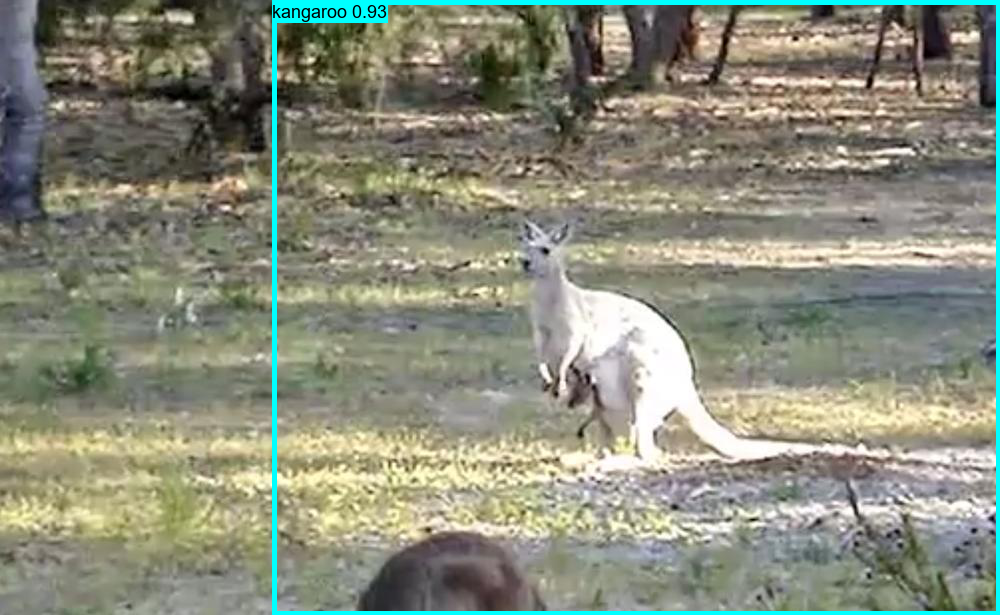

In [8]:
test = test_path + image_path
test_image_file = os.listdir(test)

# for im in test_image_file[0]:
im_path = test + "/" + test_image_file[0]
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path, anchors_path=anchors_path)
image = Image.open(im_path)
r_image = yolo_model.detect_image(image)
r_image

影像的物體偵測
===

In [26]:
# 載入訓練好的模型權重
model.load_weights('1stDL/Day049-050/logs/000/trained_weights_final.h5')

# 選擇要進行浣熊影像偵測的影像檔
kangaroo_video_input = "1stDL/Day049-050/Kangaroo.mp4"
kangaroo_video_output = "1stDL/Day049-050/Kangaroo-out.mp4"

raccoon_video_input = "1stDL/Day049-050/Raccoon.mp4"
raccoon_video_output = "1stDL/Day049-050/Raccoon-out.mp4"

def video_detect(video_path, output_path):
    startTime = time.time()
    cap = cv2.VideoCapture(video_path)
    
    # 使用 xvid 編碼
    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    
    # 建立 videowriter物件，輸出影片至output.avi，FPS 值為30.0，解析度為1280*720
    out = cv2.VideoWriter(output_path, fourcc, 30.0, (1280, 720))
    
    k = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            # 寫入影格
            image = Image.fromarray(frame)
            image = np.array(yolo_model.detect_image(image))
            out.write(image)
            k += 1
        else:
            break
    # 釋放所有資源
    cap.release()
    out.release()
    print("共耗時:", round(time.time() - startTime))
    
video_detect(video_path=kangaroo_video_input, output_path=kangaroo_video_output) 
video_detect(video_path=raccoon_video_input, output_path=raccoon_video_output) 